## 1. Dataset

repository_url: ```https://archive.ics.uci.edu/dataset/2/adult```

Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from importlib import reload

sys.path.append('/Users/cheungjustin/PycharmProjects/QuantEquity')
import pom.util as ut
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import mutual_info_classif
from collections import defaultdict

from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

In [4]:
# fetch dataset
# from ucimlrepo import fetch_ucirepo
# adult = fetch_ucirepo(id=2)
# df = adult['data']['original']

df = pd.read_csv('adult_census_income.csv', index_col=0)
target = 'income'

# Data Cleaning
df[target] = df[target].str.replace('.', '')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


## 2. EDA Wrapper

In [6]:
random_state = 4012
dta = ut.DataAnalyzer(df, target=target, cont_thres=30, random_state=random_state)

Continuous Columns:
	age
	fnlwgt
	capital-gain
	capital-loss
	hours-per-week 

Discrete Columns Encoding:
	workclass: {'?': 0, 'Federal-gov': 1, 'Local-gov': 2, 'Never-worked': 3, 'Private': 4, 'Self-emp-inc': 5, 'Self-emp-not-inc': 6, 'State-gov': 7, 'Without-pay': 8, nan: 9}
	education: {'10th': 0, '11th': 1, '12th': 2, '1st-4th': 3, '5th-6th': 4, '7th-8th': 5, '9th': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, 'Bachelors': 9, 'Doctorate': 10, 'HS-grad': 11, 'Masters': 12, 'Preschool': 13, 'Prof-school': 14, 'Some-college': 15}
	education-num: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15}
	marital-status: {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}
	occupation: {'?': 0, 'Adm-clerical': 1, 'Armed-Forces': 2, 'Craft-repair': 3, 'Exec-managerial': 4, 'Farming-fishing': 5, 'Handlers-cleaners': 6, 'Machine-op-inspct': 7, 'Other-service'

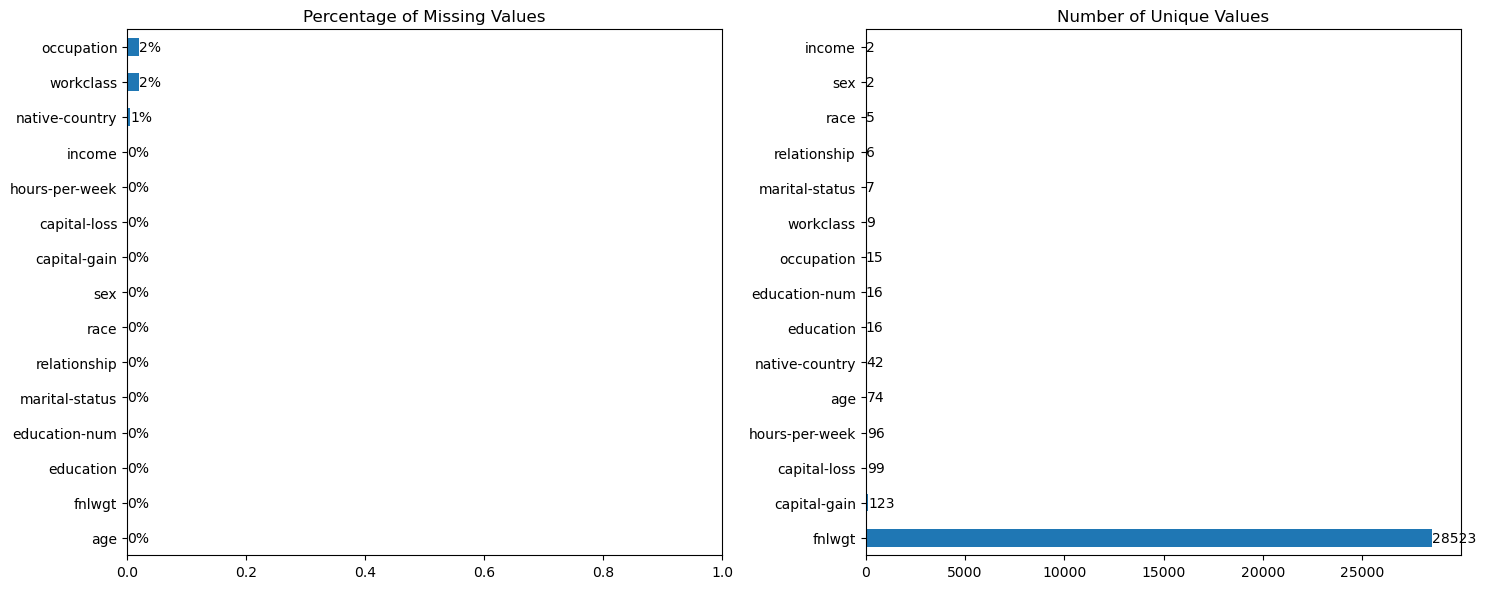

In [7]:
dta.data_quality_check();

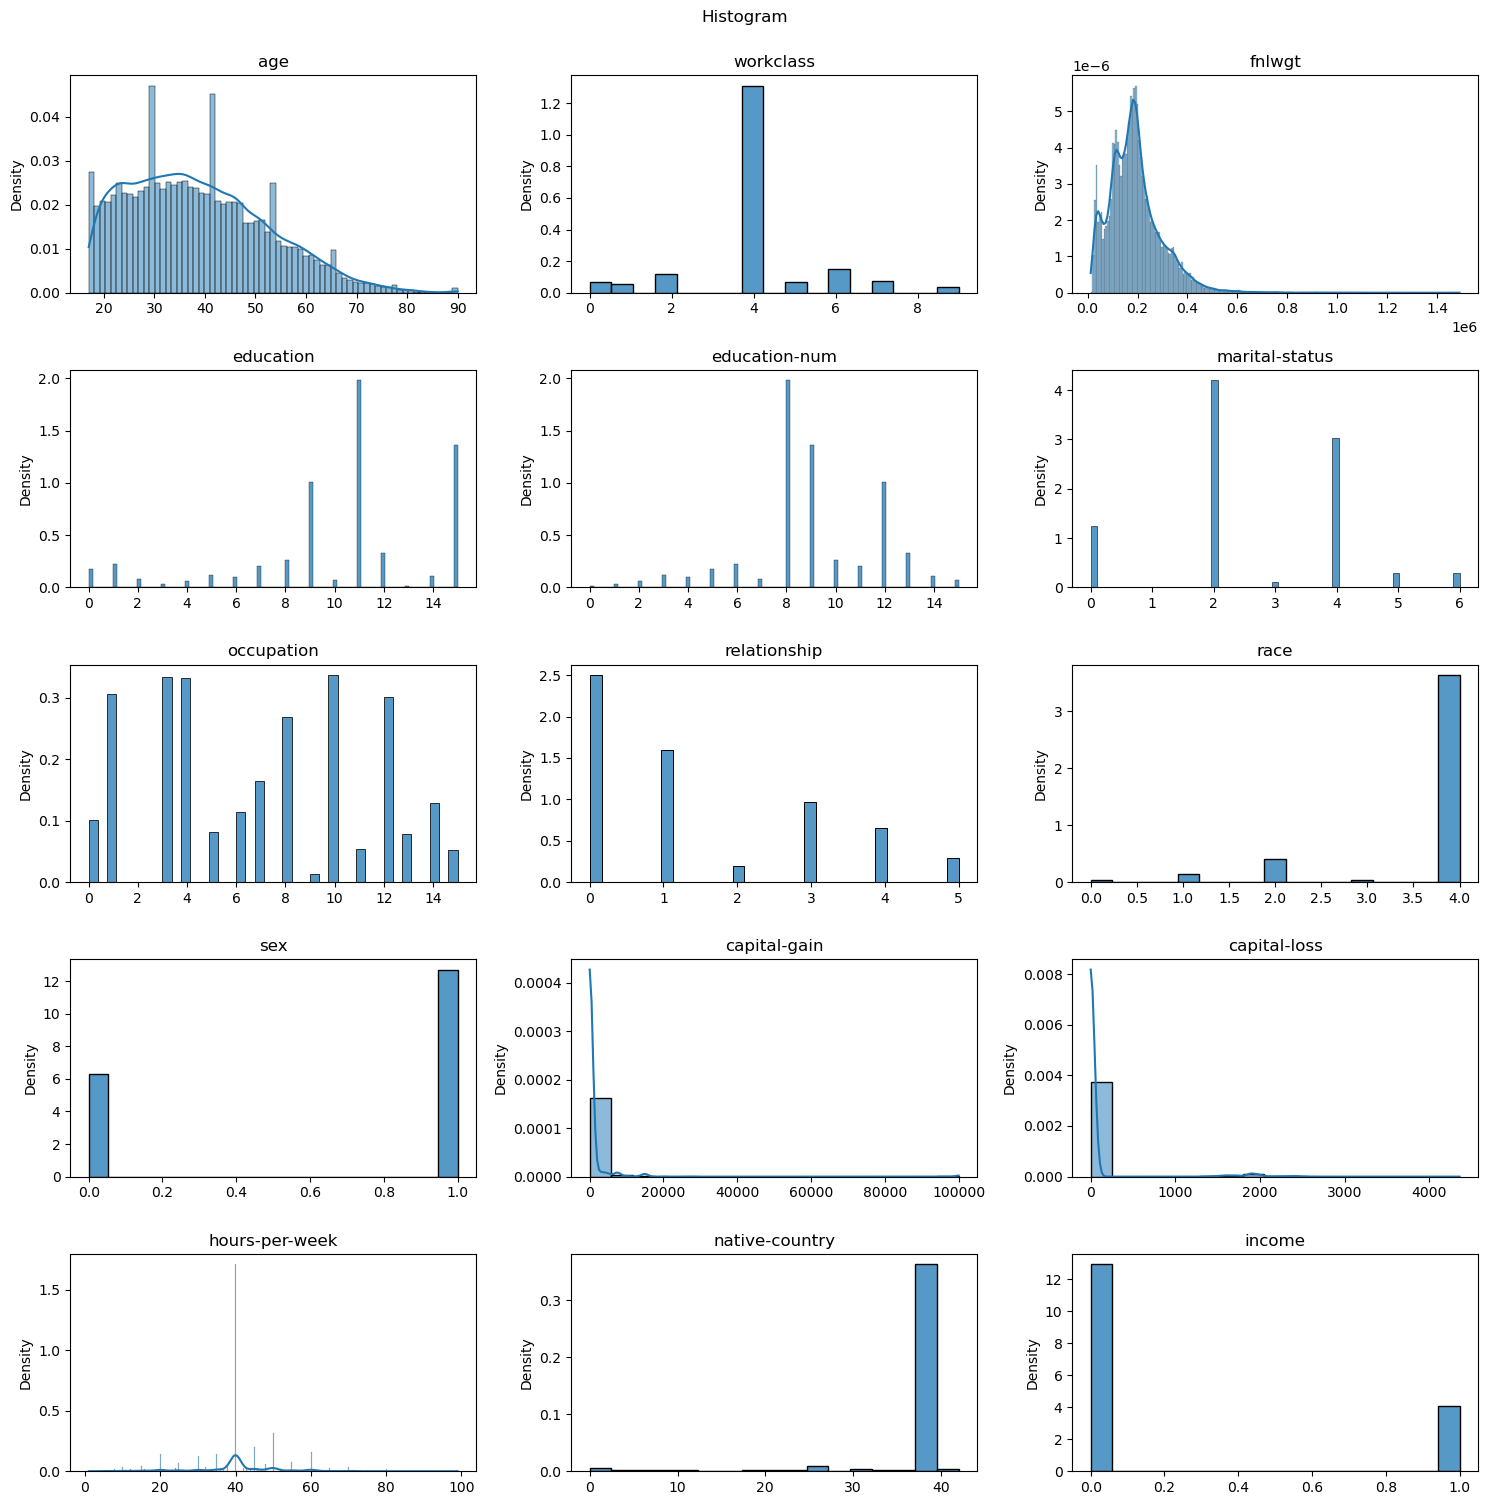

In [8]:
dta.dist_plot();

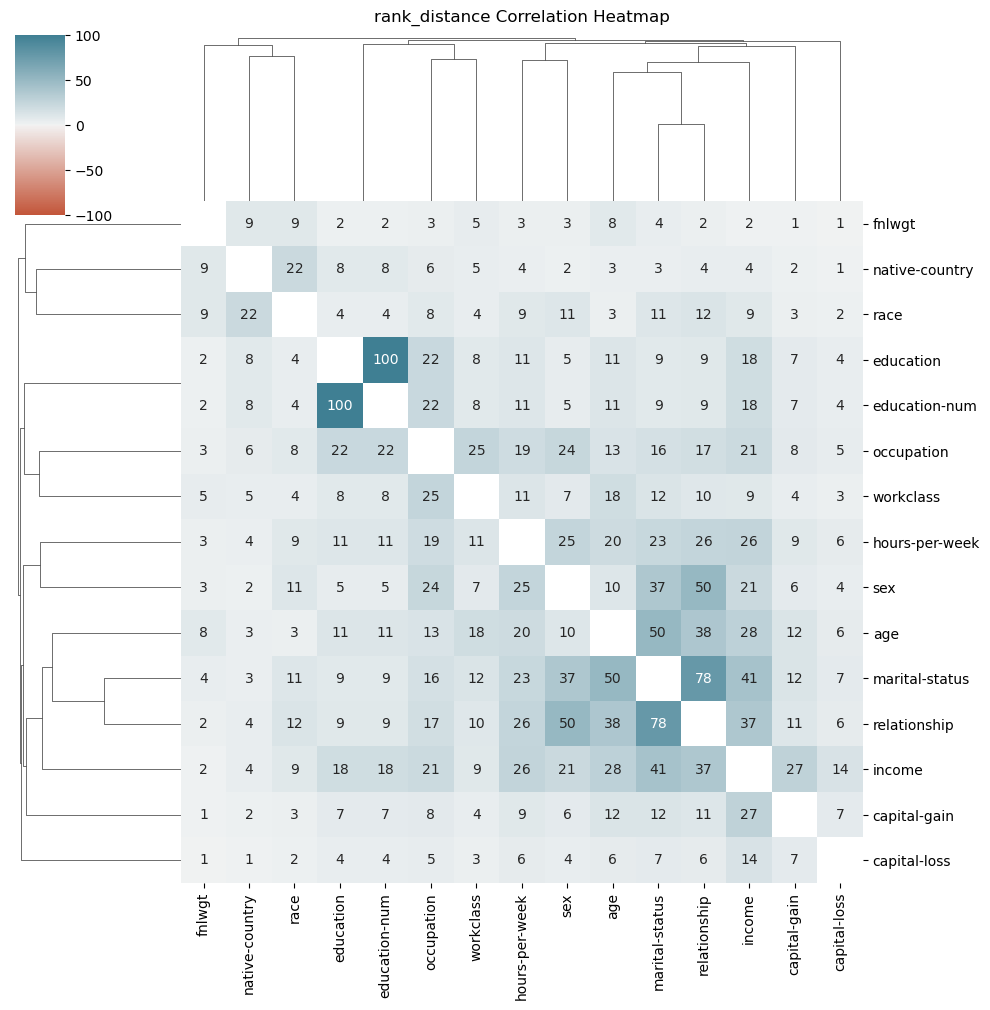

In [9]:
dta.corr_heatmap(corr_method='rank_distance', cluster=True);

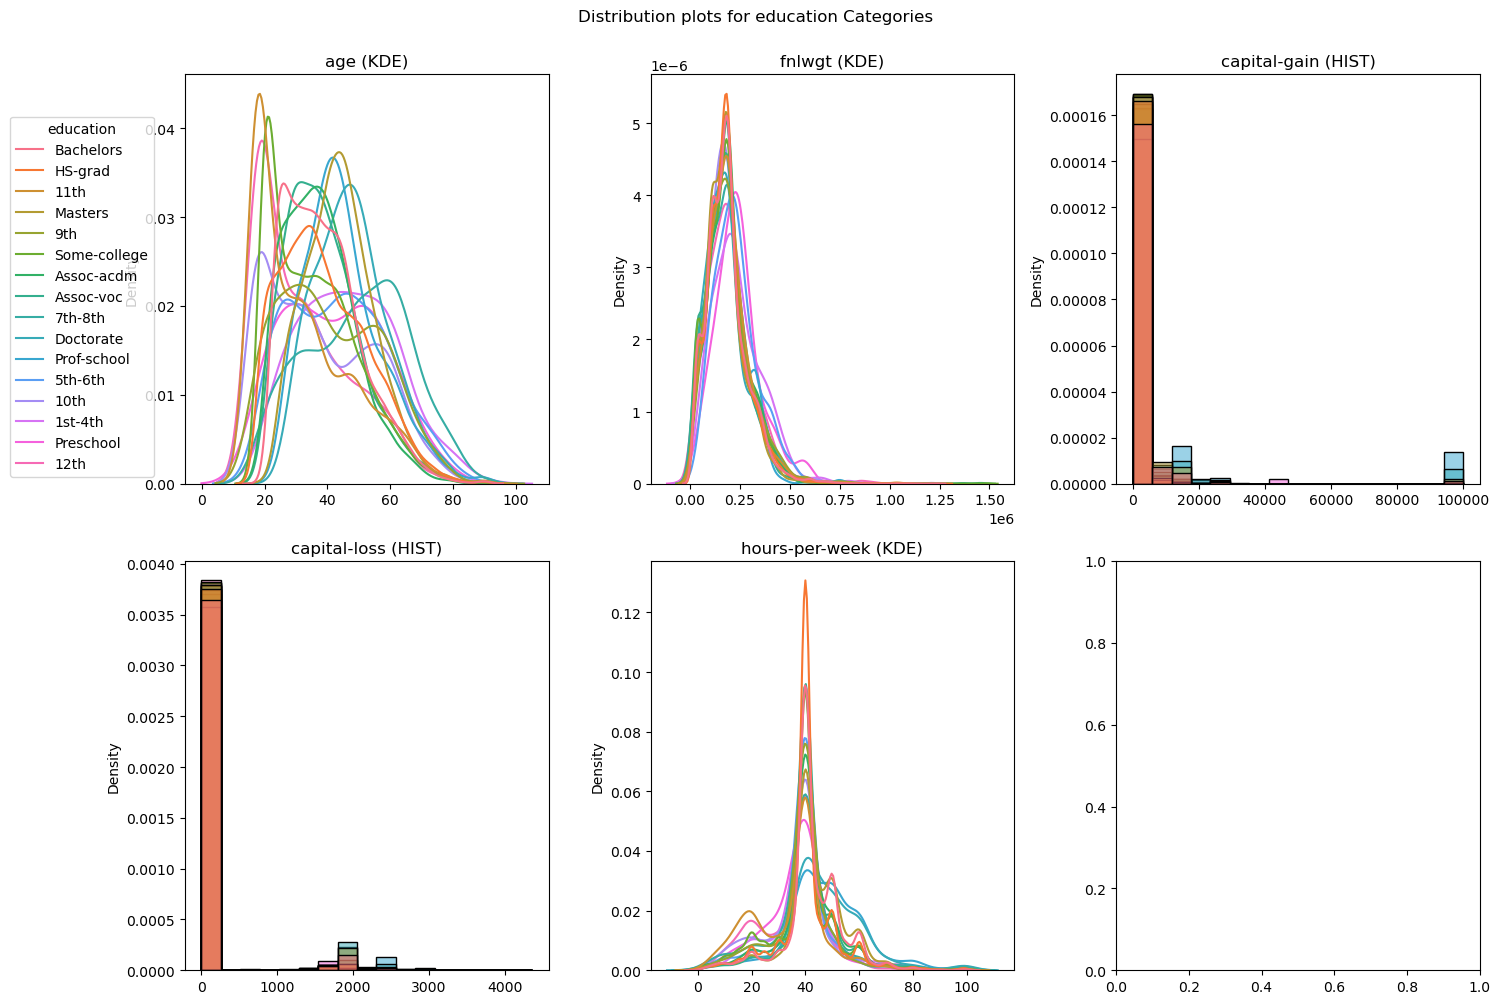

In [10]:
dta.dist_plot_by_categ('education');

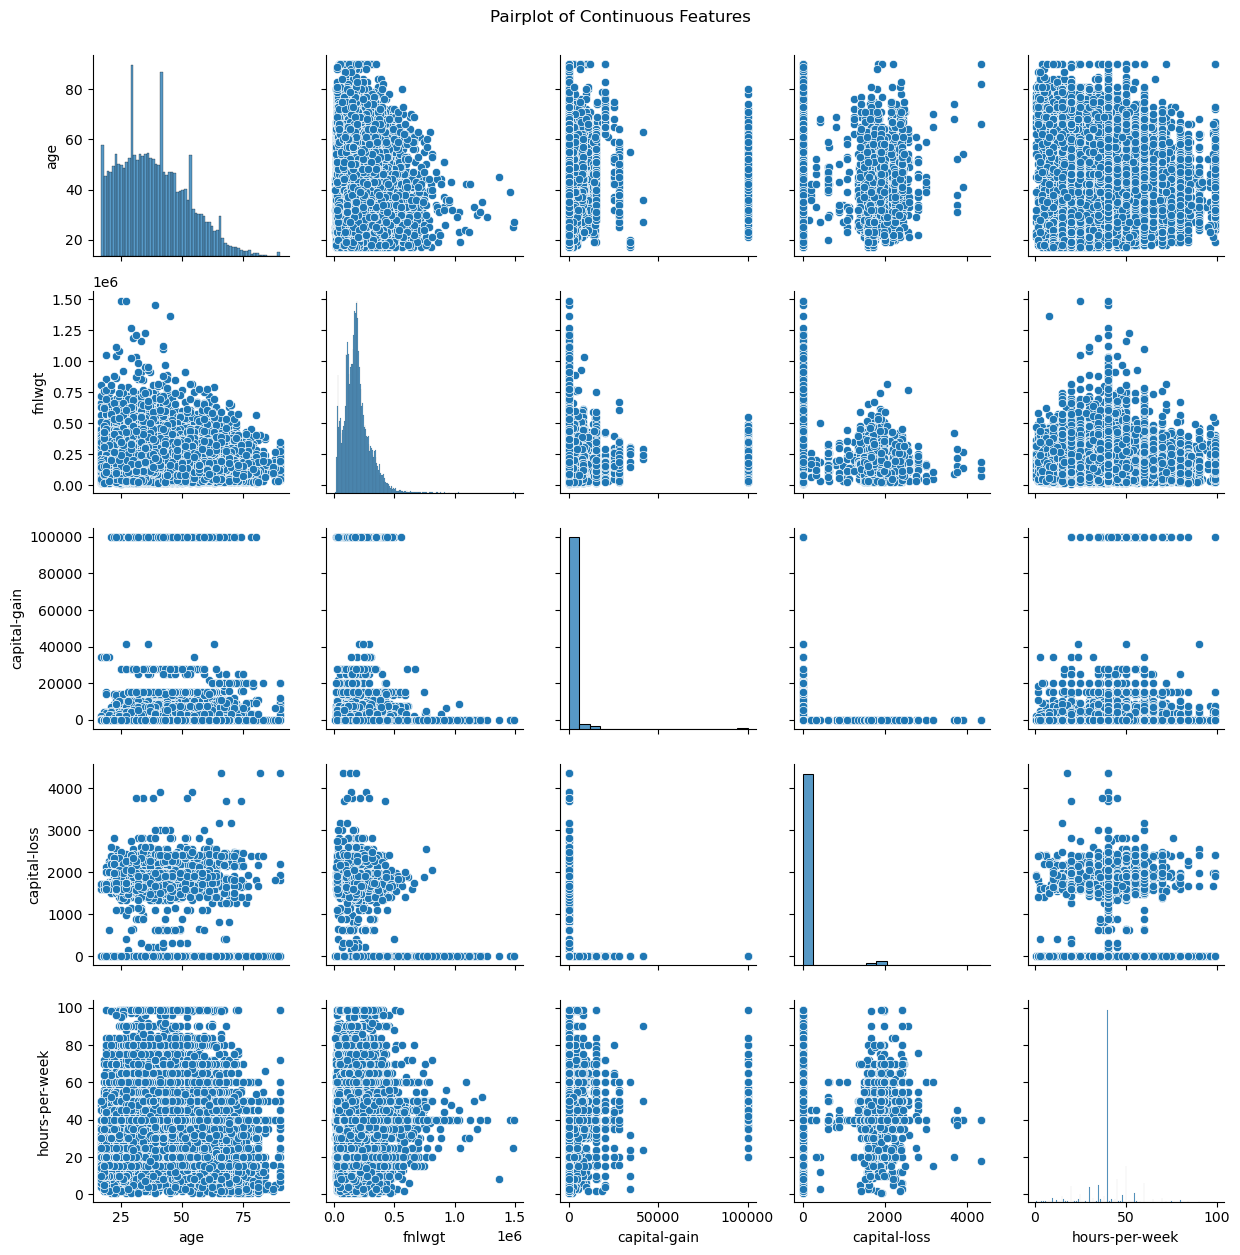

In [11]:
dta.pairplot();

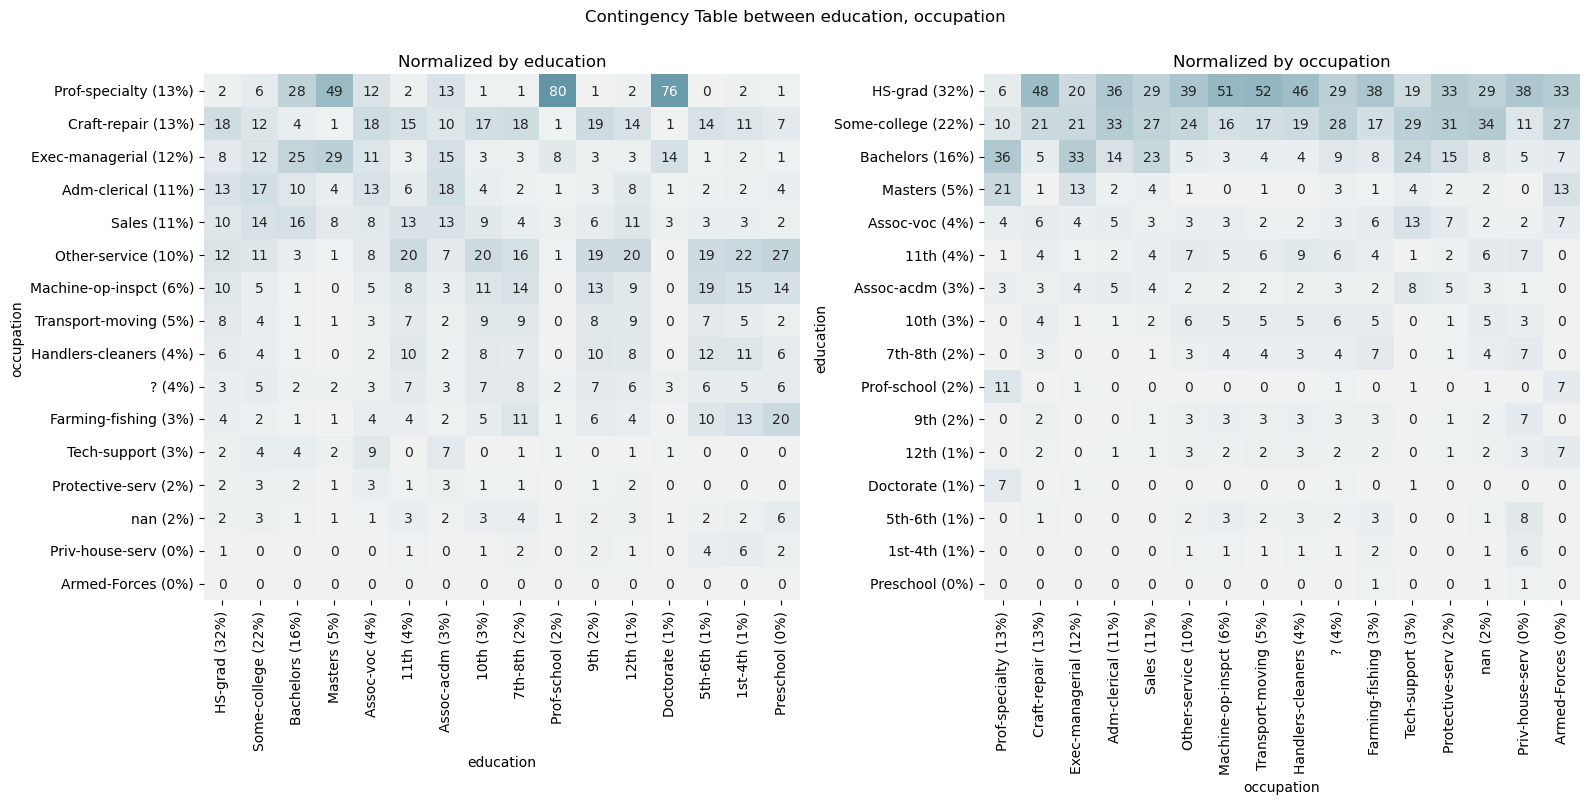

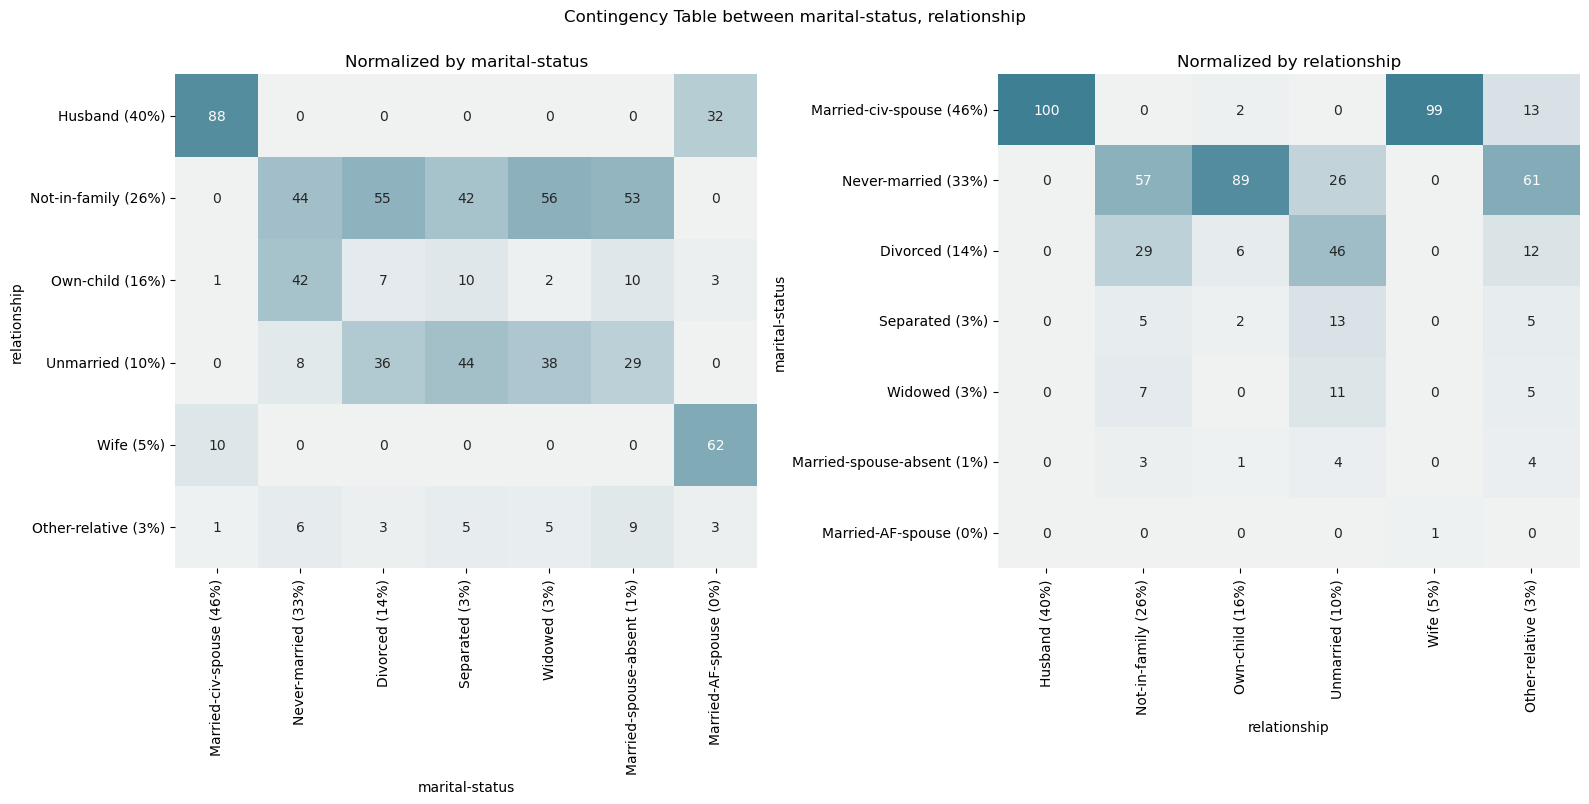

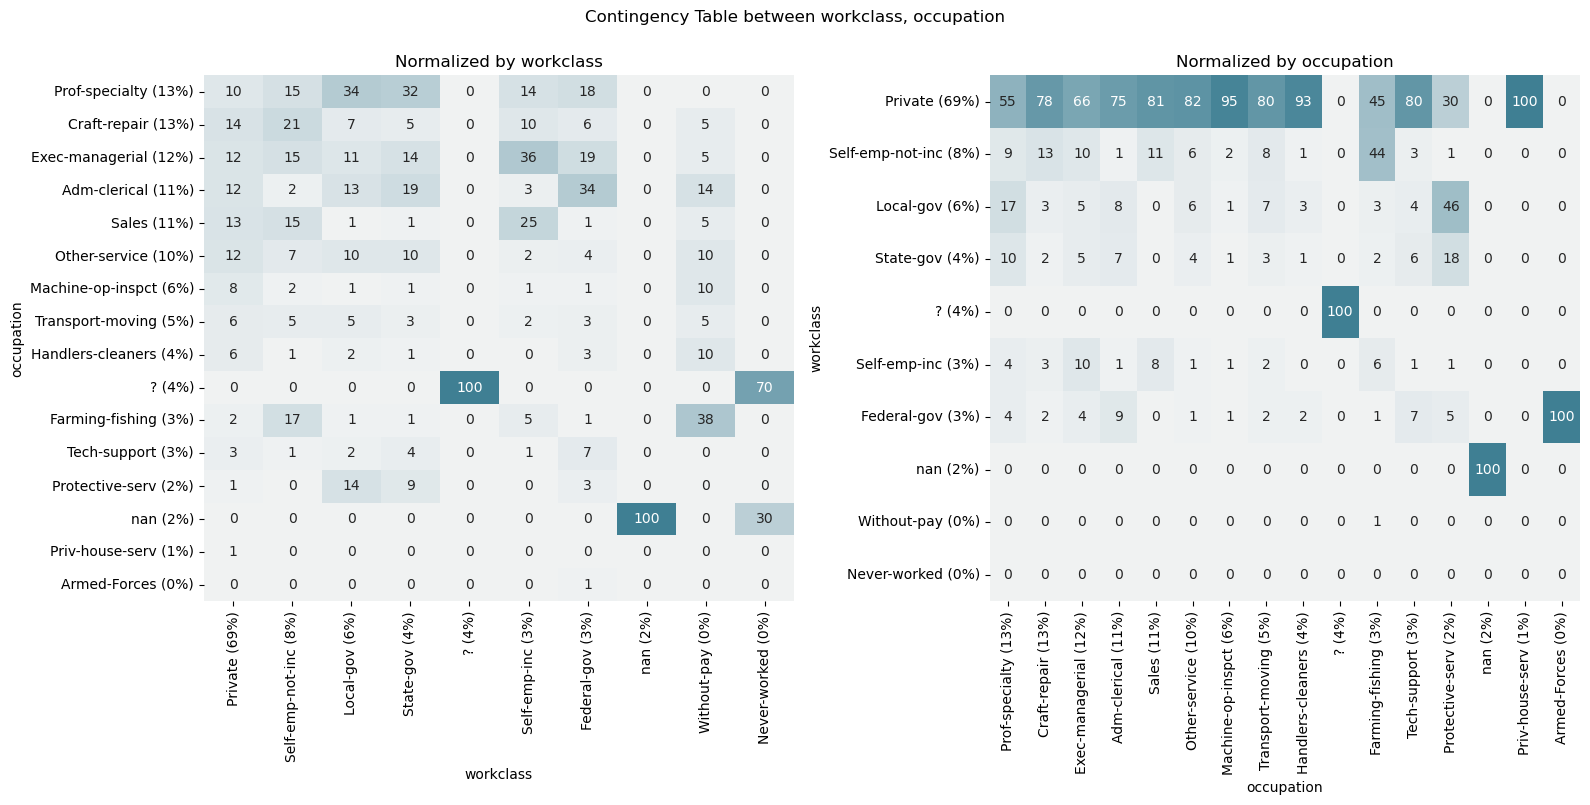

In [12]:
dta.plot_contingency('education', 'occupation');
dta.plot_contingency('marital-status', 'relationship');
dta.plot_contingency('workclass', 'occupation');

## 3. Fit Models

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from CIBer import CIBer

cont_cols = dta.cont_cols
cont_cols_idx = list(dta.map2idx(cont_cols))

CIBer = CIBer(cont_col=cont_cols_idx, asso_method='modified', min_asso=0.95,
              disc_method='wpkid', n_iter=100, joint_encode=True)

baseline_models = {
    'CIBer': CIBer, 
    'Gaussian_NB': GaussianNB(),
    'Composite_NB': ut.CompositeNB(cont_cols=cont_cols_idx),
    'SVM': SVC(kernel='linear'), 
    'Logistic': LogisticRegression(max_iter=1000),
    'MLP': MLPClassifier(max_iter=1000),
    'LDA': LinearDiscriminantAnalysis(),
    'LDA_PCA': Pipeline([
        ('pca', PCA(n_components=0.99)),
        ('lda', LinearDiscriminantAnalysis())]),
    'Decision_Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [15]:
n_iterations = 300
split_kws = {'max_batch_size': 10000,
             'test_size': 0.2, 
             'q_clip': 0.01, 
             'scaler': 'Standard', 
             'oversample': False}

class_reps = defaultdict(dict)

def _run_one(t):
    class_reps = {}
    X_train, X_test, y_train, y_test = dta.split_data(random_state=random_state + t, **split_kws)
        
    for name, model in baseline_models.items():
        model.fit(X_train.values, y_train.values)
        y_pred = model.predict(X_test.values)
        assert np.isfinite(y_pred).all()
        
        class_reps[name] = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    class_reps = pd.concat(class_reps, axis=1, names=['model', 'stat'])
    return class_reps

res = ut.parallel(_run_one, range(n_iterations), disable_par=False)
res = pd.concat(res, names=['iter', 'class'])

 69%|████████████████████████████▍            | 208/300 [02:04<01:00,  1.53it/s]/Users/cheungjustin/PycharmProjects/QuantEquity/pom/util.py:725: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_cont, X_test_cont = X_train_cont.clip(lb, ub, axis=1), X_test_cont.clip(lb, ub, axis=1)
/Users/cheungjustin/PycharmProjects/QuantEquity/pom/util.py:725: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats expl

/var/folders/cm/9l2pfgfj3c7b3t18cyph49580000gn/T/ipykernel_87109/2440316972.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for stat, stat_table in stats.groupby('stat', axis=1, sort=False):


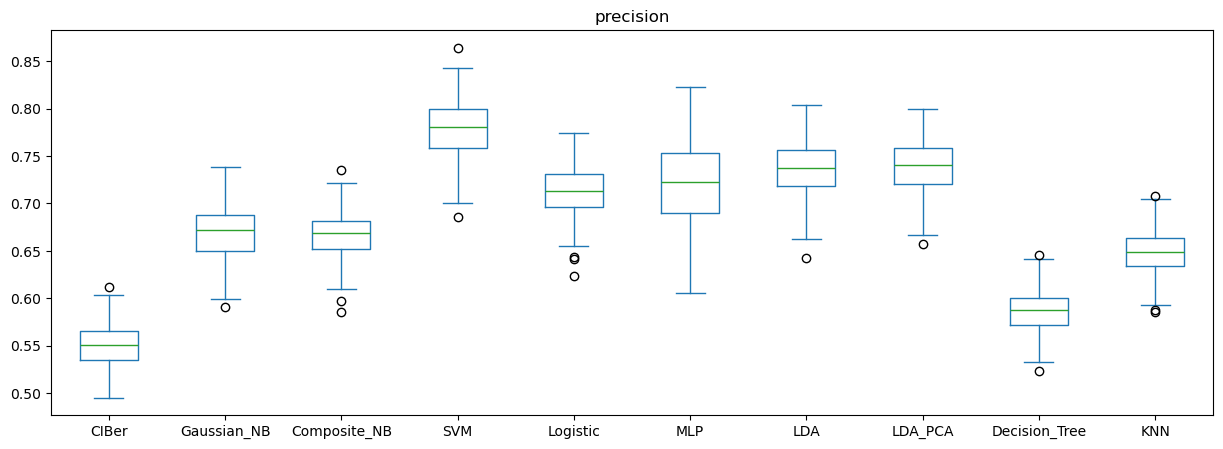

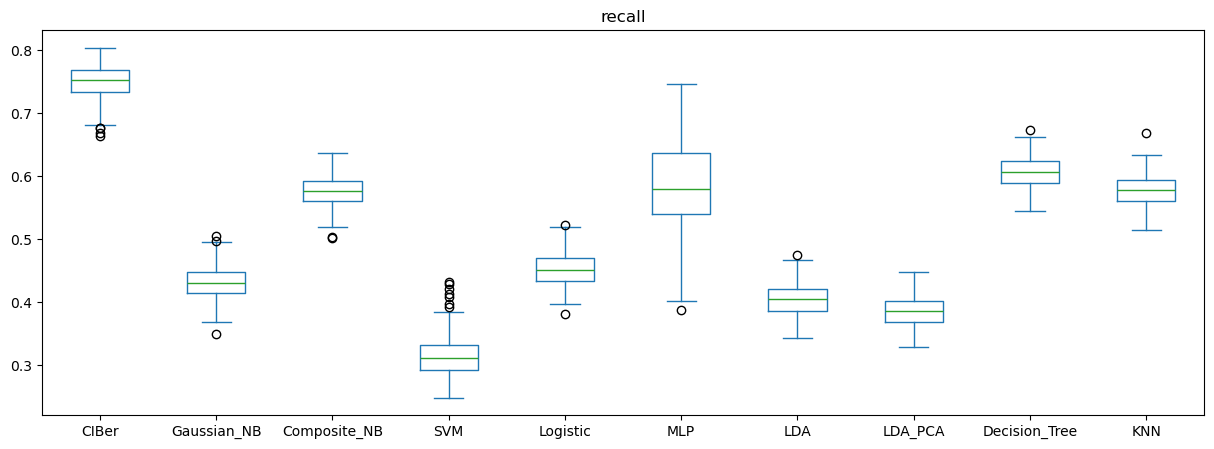

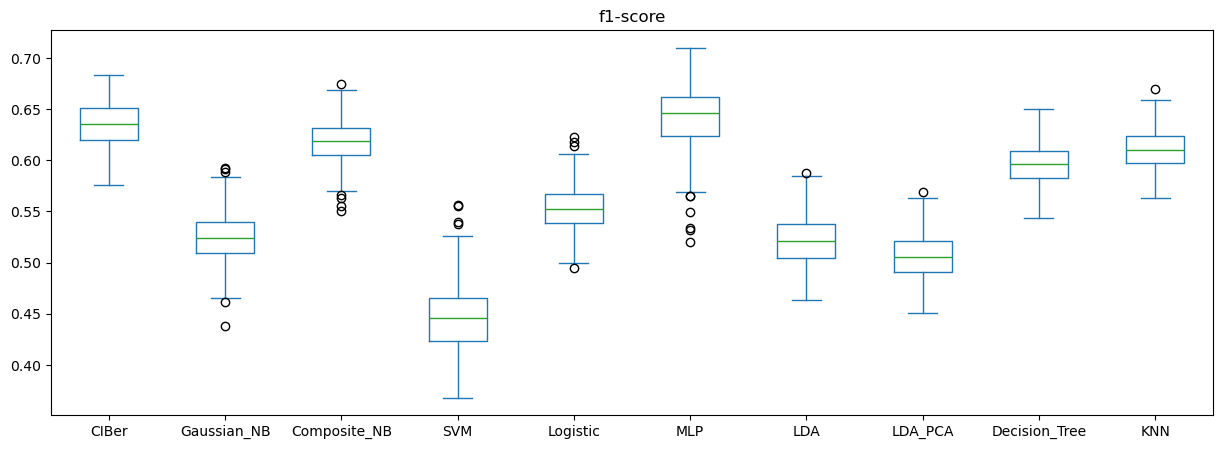

In [16]:
stats = res.drop(columns='support', level='stat', axis=1).xs("1", level='class')

for stat, stat_table in stats.groupby('stat', axis=1, sort=False):
    stat_table = stat_table.xs(stat, level='stat', axis=1)
    stat_table.plot(kind='box', title=stat, figsize=(15, 5))